# RenAIssance OCR Model Testing Notebook
## This notebook integrates CRAFT, PSENet and DBNet for comparative text detection.


#### Setup & Requirements


In [150]:
%pip install -q gdown opencv-python matplotlib scikit-image pytorch-lightning


Note: you may need to restart the kernel to use updated packages.


#### Clone PSENet and DBNet Repos

In [ ]:
!git clone https://github.com/whai362/PSENet.git
!git clone https://github.com/MhLiao/DB.git
!git clone https://github.com/kaoreill/CRAFTModel.git



fatal: destination path 'PSENet' already exists and is not an empty directory.
fatal: destination path 'DB' already exists and is not an empty directory.
fatal: destination path 'CRAFTModel' already exists and is not an empty directory.
Cloning into 'CRAFT-pytorch'...


#### Download pretrained weights

In [ ]:
import os
import urllib.request

# Destination directory
checkpoint_dir = os.path.join("db", "weights")
os.makedirs(checkpoint_dir, exist_ok=True)

# List of model URLs
urls = [
    "https://download.openmmlab.com/mmocr/textdet/dbnetpp/dbnetpp_resnet50_fpnc_1200e_icdar2015/dbnetpp_resnet50_fpnc_1200e_icdar2015_20221025_185550-013730aa.pth",
    "https://download.openmmlab.com/mmocr/textdet/dbnetpp/dbnetpp_resnet50-dcnv2_fpnc_1200e_icdar2015/dbnetpp_resnet50-dcnv2_fpnc_1200e_icdar2015_20220829_230108-f289bd20.pth",
    "https://download.openmmlab.com/mmocr/textdet/dbnetpp/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015_20221101_124139-4ecb39ac.pth"
]

# Download each model
for url in urls:
    filename = os.path.join(checkpoint_dir, os.path.basename(url))
    print(f"Downloading to: {filename}")
    urllib.request.urlretrieve(url, filename)
    print(f"Downloaded: {os.path.basename(url)}")

print("\nAll DBNet++ weights downloaded successfully.")


In [ ]:
import os
import urllib.request

# Target directory for PSENet weights
checkpoint_dir = os.path.join("PSENet", "weights")
os.makedirs(checkpoint_dir, exist_ok=True)

# List of download URLs for PSENet models
urls = [
    "https://download.openmmlab.com/mmocr/textdet/psenet/psenet_resnet50_fpnf_600e_ctw1500/psenet_resnet50_fpnf_600e_ctw1500_20220825_221459-7f974ac8.pth",
    "https://download.openmmlab.com/mmocr/textdet/psenet/psenet_resnet50-oclip_fpnf_600e_ctw1500/psenet_resnet50-oclip_fpnf_600e_ctw1500_20221101_140406-d431710d.pth",
    "https://download.openmmlab.com/mmocr/textdet/psenet/psenet_resnet50_fpnf_600e_icdar2015/psenet_resnet50_fpnf_600e_icdar2015_20220825_222709-b6741ec3.pth",
    "https://download.openmmlab.com/mmocr/textdet/psenet/psenet_resnet50-oclip_fpnf_600e_icdar2015/psenet_resnet50-oclip_fpnf_600e_icdar2015_20221101_131357-2bdca389.pth"
]

# Download loop
for url in urls:
    filename = os.path.join(checkpoint_dir, os.path.basename(url))
    print(f"Downloading to: {filename}")
    urllib.request.urlretrieve(url, filename)
    print(f"✔ Downloaded: {os.path.basename(url)}")

print("\n All PSENet weights downloaded successfully")


In [167]:
import os
import gdown

# Set the path to the weights folder inside CRAFT-pytorch
craft_dir = os.path.join("CRAFTModel", "weights")
os.makedirs(craft_dir, exist_ok=True)

# Dictionary of pretrained model URLs (GDrive file IDs)
urls = {
    "craft_mlt_25k.pth": "1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ",
    "craft_ic15_20k.pth": "1i2R7UIUqmkUtF0jv_3MXTqmQ_9wuAnLf",
    "craft_refiner_CTW1500.pth": "1XSaFwBkOaFOdtk4Ane3DFyJGPRw6v5bO"
}

# Download each file
for name, file_id in urls.items():
    output_path = os.path.join(craft_dir, name)
    url = f"https://drive.google.com/uc?id={file_id}"
    print(f"Downloading {name} to {output_path}...")
    gdown.download(url, output_path, quiet=False)
    print(f"✔ Downloaded {name}")

print("All CRAFT weights saved successfully.")


Downloading...
From: https://drive.google.com/uc?id=1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ
To: c:\Users\katej\OneDrive\Documents\GitHub\RenAIssance\RenAIssance_CRNN_OCR_Kate_OReilly\CRAFTModel\weights\craft_mlt_25k.pth
100%|██████████| 83.2M/83.2M [00:03<00:00, 25.2MB/s]


✔ Downloaded craft_mlt_25k.pth


Downloading...
From: https://drive.google.com/uc?id=1i2R7UIUqmkUtF0jv_3MXTqmQ_9wuAnLf
To: c:\Users\katej\OneDrive\Documents\GitHub\RenAIssance\RenAIssance_CRNN_OCR_Kate_OReilly\CRAFTModel\weights\craft_ic15_20k.pth
100%|██████████| 83.2M/83.2M [00:03<00:00, 24.8MB/s]


✔ Downloaded craft_ic15_20k.pth


Downloading...
From: https://drive.google.com/uc?id=1XSaFwBkOaFOdtk4Ane3DFyJGPRw6v5bO
To: c:\Users\katej\OneDrive\Documents\GitHub\RenAIssance\RenAIssance_CRNN_OCR_Kate_OReilly\CRAFTModel\weights\craft_refiner_CTW1500.pth
100%|██████████| 1.85M/1.85M [00:00<00:00, 8.47MB/s]

✔ Downloaded craft_refiner_CTW1500.pth
All CRAFT weights saved successfully.


#### Import Modules

In [154]:
import os
import cv2
import torch

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from jiwer import wer, cer
import editdistance

import os
import sys

project_root = os.path.abspath("CRAFTModel")
if project_root not in sys.path:
    sys.path.append(project_root)

print("Resolved project root:", project_root)
print("Files in that directory:", os.listdir(project_root))


from pathlib import Path
from torchvision import transforms
import importlib.util

craft_path = os.path.abspath("CRAFTModel/craft.py")
spec = importlib.util.spec_from_file_location("craft", craft_path)
craft_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(craft_module)

CRAFT = craft_module.CRAFT

from craft_utils import getDetBoxes
from imgproc import normalizeMeanVariance
from PIL import Image

Resolved project root: c:\Users\katej\OneDrive\Documents\GitHub\RenAIssance\RenAIssance_CRNN_OCR_Kate_OReilly\CRAFTModel
Files in that directory: ['.git', '.gitignore', 'craft.py', 'craft_utils.py', 'file_utils.py', 'imgproc.py', 'LICENSE', 'refinenet.py', 'requirements.txt', 'test.py']


#### Read Renaissance Images

In [155]:
image_folder = "./data/imgsForAllPages"
image_paths = sorted(glob(os.path.join(image_folder, '*.jpg')) + glob(os.path.join(image_folder, '*.png')))

#### Display first image

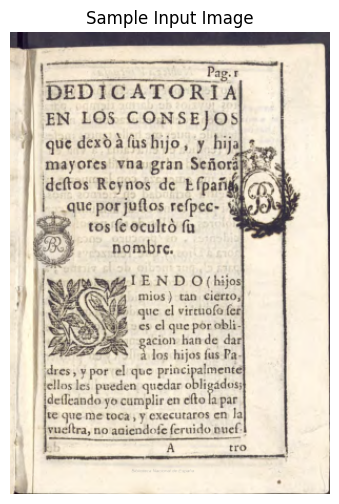

In [156]:
sample_image_path = image_paths[0]
img = cv2.imread(sample_image_path)
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Input Image")
plt.axis("off")
plt.show()

#### Configuration

In [157]:
INPUT_FOLDER = 'data/imgsForAllPages'
CRAFT_MODEL_PATH = 'CRAFT-pytorch/weights/craft_mlt_25k.pth'
OUTPUT_OVERLAY = 'output/craft/overlays'
OUTPUT_BOXES = 'output/craft/boxes'

os.makedirs(OUTPUT_OVERLAY, exist_ok=True)
os.makedirs(OUTPUT_BOXES, exist_ok=True)

#### Utility Functions

In [164]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return np.array(image)

def save_overlay(image, boxes, save_path):
    for box in boxes:
        pts = np.array(box).reshape((-1, 1, 2)).astype(np.int32)
        cv2.polylines(image, [pts], True, (0, 255, 0), thickness=2)
    cv2.imwrite(save_path, image)

def save_boxes_txt(boxes, save_path):
    with open(save_path, 'w') as f:
        for box in boxes:
            flattened = [str(coord) for point in box for coord in point]
            f.write(','.join(flattened) + '\n')

#### Load CRAFT Model

In [168]:
# Path to your model
CRAFT_MODEL_PATH = 'CRAFTModel/weights/craft_mlt_25k.pth'

# Initialize the model
craft_net = CRAFT()

# Load weights and remove 'module.' prefixes
state_dict = torch.load(CRAFT_MODEL_PATH, map_location='cpu')
new_state_dict = {}

for k, v in state_dict.items():
    new_key = k.replace('module.', '')  # strip 'module.' if present
    new_state_dict[new_key] = v

# Load the cleaned state_dict
craft_net.load_state_dict(new_state_dict)

# Set model to evaluation mode
craft_net.eval()

print("CRAFT model loaded successfully.")



CRAFT model loaded successfully.


#### Run Detection

In [170]:
import torch
import numpy as np
import cv2
from PIL import Image
from craft_utils import getDetBoxes
from imgproc import normalizeMeanVariance

def run_craft(image_np, debug=False):
    # Resize to match model input
    image_resized = cv2.resize(image_np, (1280, 1280))
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    
    # Normalize
    norm_image = normalizeMeanVariance(image_rgb)
    norm_image = norm_image.transpose(2, 0, 1)  # HWC → CHW
    norm_tensor = torch.from_numpy(norm_image).unsqueeze(0).float()

    # Inference
    with torch.no_grad():
        y, _ = craft_net(norm_tensor)

    # Get boxes
    score_text = y[0, :, :, 0].cpu().numpy()
    score_link = y[0, :, :, 1].cpu().numpy()
    boxes, _ = getDetBoxes(score_text, score_link, 0.8, 0.6, 0.5, False)

    if debug:
        print(f"Detected {len(boxes)} boxes.")
        if len(boxes) == 0:
            print(" No text regions found. Try lowering thresholds or preprocessing.")

    return boxes


#### Main Loop

In [172]:
image_paths = list(Path(INPUT_FOLDER).glob("*.jpg")) + list(Path(INPUT_FOLDER).glob("*.png"))

for img_path in image_paths:
    filename = img_path.stem
    image_np = load_image(str(img_path))
    boxes = run_craft(image_np)

    overlay_path = os.path.join(OUTPUT_OVERLAY, f"{filename}_overlay.jpg")
    txt_path = os.path.join(OUTPUT_BOXES, f"{filename}.txt")

    save_overlay(image_np.copy(), boxes, overlay_path)
    save_boxes_txt(boxes, txt_path)

    print(f"Processed {filename}")


Processed image_1
Processed image_10
Processed image_11
Processed image_12
Processed image_13
Processed image_14
Processed image_15
Processed image_16
Processed image_17
Processed image_18
Processed image_19
Processed image_2
Processed image_20
Processed image_21
Processed image_22
Processed image_23
Processed image_24
Processed image_25
Processed image_26
Processed image_27
Processed image_28
Processed image_29
Processed image_3
Processed image_30
Processed image_31
Processed image_4
Processed image_5
Processed image_6
Processed image_7
Processed image_8
Processed image_9


#### Viusal Representation of Bounding Boxes

In [174]:
import os
import cv2

def draw_bounding_boxes(image_path, boxes_path, output_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Could not read {image_path}")
        return

    with open(boxes_path, 'r') as f:
        lines = f.read().split(';')  

    for group in lines:
        for line in group.strip().splitlines():
            try:
                coords = list(map(float, line.strip().split(',')))
                if len(coords) == 8:
                    pts = [(int(coords[i]), int(coords[i+1])) for i in range(0, 8, 2)]
                    for j in range(4):
                        cv2.line(image, pts[j], pts[(j+1)%4], (0, 255, 0), 2)
            except ValueError:
                print(f"Skipping malformed line: {line}")
                continue

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, image)



In [161]:


INPUT_FOLDER = "data/imgsForAllPages"
OUTPUT_BOXES = "output/craft/boxes"         # or wherever your unsorted boxes are
OUTPUT_OVERLAY = "output/craft/overlays"

os.makedirs(OUTPUT_OVERLAY, exist_ok=True)

for file in os.listdir(OUTPUT_BOXES):
    if file.endswith(".txt"):
        base_name = os.path.splitext(file)[0]  # removes .txt
        image_name = base_name + ".png"
        image_path = os.path.join(INPUT_FOLDER, image_name)
        boxes_path = os.path.join(OUTPUT_BOXES, file)
        output_path = os.path.join(OUTPUT_OVERLAY, image_name)

        draw_bounding_boxes(image_path, boxes_path, output_path)



In [200]:
import os

def sort_bounding_boxes(input_dir, output_dir):
    """
    Sorts bounding boxes in .txt files (format: x1,y1,x2,y2,x3,y3,x4,y4) by top-to-bottom and left-to-right
    and writes the sorted results to a new folder.
    """
    for filename in os.listdir(input_dir):
        if filename.endswith(".txt"):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            with open(input_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()

            boxes = []
            for line in lines:
                coords = list(map(float, line.strip().split(',')))
                if len(coords) == 8:
                    # Average y to sort top-down
                    avg_y = (coords[1] + coords[3] + coords[5] + coords[7]) / 4.0
                    avg_x = (coords[0] + coords[2] + coords[4] + coords[6]) / 4.0
                    boxes.append((avg_y, avg_x, line))

            # Sort by y, then x
            boxes.sort()
            with open(output_path, 'w', encoding='utf-8') as f:
                for _, _, line in boxes:
                    f.write(line)


In [201]:
import os
import subprocess
import sys
from glob import glob

python_exe = sys.executable  # Path to active Python interpreter

# Define paths
CRAFT_SCRIPT = "CRAFTModel/test.py"
IMG_FOLDER = "data/imgsForAllPages"
OUTPUT_BOXES = "output/craft/boxes"
WEIGHTS = "CRAFTModel/weights/craft_mlt_25k.pth"

# Step 1: Run CRAFT
os.makedirs(OUTPUT_BOXES, exist_ok=True)

try:
    subprocess.run([
        python_exe,
        CRAFT_SCRIPT,
        f"--trained_model={WEIGHTS}",
        f"--test_folder={IMG_FOLDER}"
    ], capture_output=True, text=True, check=True)
except subprocess.CalledProcessError as e:
    print("CRAFT script failed.")
    print("Exit Code:", e.returncode)
    print("Stderr:", e.stderr)
    sys.exit(1)

# Step 2: Sort bounding boxes
INPUT_DIR = OUTPUT_BOXES
OUTPUT_DIR = "output/craft/boxes_sorted"
os.makedirs(OUTPUT_DIR, exist_ok=True)
sort_bounding_boxes(INPUT_DIR, OUTPUT_DIR)

print("✅ CRAFT detection + sorting + overlay complete")


✅ CRAFT detection + sorting + overlay complete
